In [24]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter

In [25]:
class HardSVC:
    def fit(self, X, y, selections=None):
        a = np.zeros(X.shape[0])
        ay = 0
        ayx = np.zeros(X.shape[1])
        yx = y.reshape(-1, 1)*X
        indices = np.arange(X.shape[0])
        while True:
            # yt▽f(a)tを計算
            ydf = y*(1 - np.dot(yx, ayx.T))
            
            # i, jを取り出す
            iydf = np.c_[indices, ydf]
            i = int(min(iydf[(y < 0) | (a < 0)],
                        key = itemgetter(1))[0])
            j = int(max(iydf[(y > 0) | (a < 0)],
                        key = itemgetter(1))[0])
            
            # iにおける最小値 > jにおける最大値の条件を満たしていたらiterationを終了する
            if ydf[i] >= ydf[j]:
                break
            
            # 効率よく計算するために，更新されたaの差分だけを計算している
            ay2 = ay - y[i]*a[i] - y[j]*a[j]
            ayx2 = ayx - y[i]*a[i]*X[i, :] - y[j]*a[j]*X[j, :]
            
            # 新しいaiを計算（a^i）
            ai = ((1-y[i]*y[j]
                   + y[i]*np.dot(X[i, :] - X[j, :],
                                 X[j, :]*ay2 - ayx2))
                  / ((X[i] - X[j]) ** 2).sum())
            
            # ai < 0だったらai = 0が実質最適解
            if ai < 0:
                ai = 0
            
            aj = (-ai * y[i] - ay2) * y[j]
            
            # aj< 0だったらaj = 0が実質最適解
            if aj < 0:
                aj = 0
                ai = (-aj * y[j] - ay2) * y[j]
                
            ay += y[i]*(ai - a[i]) + y[j]*(aj - a[j])
            ayx += y[i]*(ai - a[i])*X[i, :] + y[j]*(aj - a[j])*X[j, :]
            
            # ai<0だったらai=0(ajも同様）にするのを繰り返し行うため，もしも前回と結果が一致していたらiterationを終了する
            if ai == a[i]:
                break
            
            a[i] = ai
            a[j] = aj
            
        self.a_ = a
        ind = a != 0.
        self.w_ = ((a[ind] * y[ind]).reshape(-1, 1)
                    * X[ind, :]).sum(axis=0)
        self.w0_ = (y[ind]
                    - np.dot(X[ind, :], self.w_)).sum() / ind.sum()
        
    def predict(self, X):
        return np.sign(self.w0_ + np.dot(X, self.w_))

In [26]:
def hard_classify(seed, num, dim=2):
    plt.axes().set_aspect('equal')
    
    # create random data
    np.random.seed(seed)
    X0 = np.random.randn(num, dim)
    X1 = np.random.randn(num, dim) + np.array([5 for _ in range(dim)])
    y = np.array([1] * num + [-1] * num)
    
    X = np.r_[X0, X1]

    # define the model
    model = HardSVC()
    model.fit(X, y)
    
    # visualize the random data
    if dim == 2:
        plt.scatter(X0[:, 0], X0[:, 1], color='k', marker='+')
        plt.scatter(X1[:, 0], X1[:, 1], color='k', marker='*')

    def f(model, x):
        return (-model.w0_ - model.w_[0] * x) / model.w_[1]
    
    x1 = -0.2
    x2 = 6
    
    # 分類超平面を描画
    plt.plot([x1, x2], [f(model, x1), f(model, x2)], color='k')
    
    # aのなかの非ゼロ成分， すなわち対応するxがサポートベクタになるものに○をつける
    plt.scatter(X[model.a_ != 0, 0], X[model.a_ != 0, 1],
                s=200, color=(0, 0, 0, 0), edgecolor='k', marker='o')
    
    plt.show()

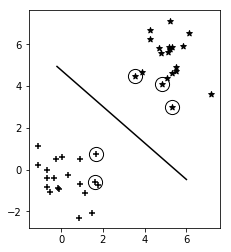

In [27]:
hard_classify(1, 20)